In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1))
                         

In [3]:
class dense_block(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(dense_block, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(conv_block(input_channels + num_channels* i, num_channels))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        for layer in self.net:
            y = layer(X)
            X = torch.cat((X,y), dim=1)
        return X

In [4]:
blk = dense_block(2, 3, 10)

X = torch.randn(4,3,8,8)

y = blk(X)
y.shape

torch.Size([4, 23, 8, 8])

In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
        
    )

In [6]:
blk = transition_block(23,10)
blk(y).shape

torch.Size([4, 10, 4, 4])

In [7]:
# creating Densenet

b1 = nn.Sequential(nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
num_channels = 64
growth_rate = 32

num_of_convs_in_dense_blocks = [4,4,4,4]

blks = []

for i, num_convs in enumerate(num_of_convs_in_dense_blocks):
    blks.append(dense_block(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_of_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels//2))
        num_channels = num_channels // 2

In [9]:
net= nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels),nn.ReLU(),
                   nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(num_channels, 10))

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
#d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [11]:
from torchsummary import summary

summary(net.to(torch.device('cuda')), (1,96,96))

z:\installs\anconda\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

## Exercises
1. Why do we use average pooling rather than maximum pooling in the transition layer?
- so that theother cells may not be eliminated and have some value addition in the model

2. One of the advantages mentioned in the DenseNet paper is that its model parameters are
smaller than those of ResNet. Why is this the case?
- because of less number of linear layers, more memory is utilised instead disk space( I am ssuming because of the follow up question given below)

```
Total params: 758,226
Trainable params: 758,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 14.29
Params size (MB): 2.89
Estimated Total Size (MB): 17.22
```

This is the disk space, while the memory used in 3.1 GB.

3. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to 224 × 224 to see the actual GPU
    memory consumption.
    - all right weiil have to try
    
    2. Can you think of an alternative means of reducing the memory consumption? How
    would you need to change the framework?
    - no Idea
4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper
(Huang et al., 2017).

- https://arxiv.org/pdf/1608.06993.pdf

5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price
prediction task in Section 4.10.

-  This is a task! But how? I am low on motivation.


In [12]:
# training loop for densenet

def train_net(net, train_dataloader, test_dataloader, n_epochs=10, lr=0.1, batch_size=256,device=torch.device('cuda')):
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
        
    net.apply(init_weights)
    print('training on: ', device)
    net = net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr )
    loss_criterion = nn.CrossEntropyLoss()
    
    def accuracy(y_hat, y):
        return (torch.argmax(y_hat, dim=1) == y).sum().float().mean()
    
    train_acc_arr = []
    train_loss_arr = []
    test_acc_arr = []
    
    for epoch in range(n_epochs):
        net.train()
        train_acc = 0
        train_loss = 0
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
        
            y_hat = net(X)
            train_acc += accuracy(y_hat, y).item()
            #print(train_acc * len(y))
            optimizer.zero_grad()
            loss = loss_criterion(y_hat, y)
            train_loss += loss.item()
            
            #print(train_loss*10, train_acc/10)
            
            loss.backward()
            
            optimizer.step()
            
        net.eval()
        test_acc = 0
        with torch.no_grad():
            
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
            
                y_hat = net(X)
                test_acc += accuracy(y_hat, y).item()
        
        test_acc_arr.append(test_acc/len(y))
                
        train_acc_arr.append(train_acc/len(y))
        train_loss_arr.append(train_loss/len(y))
        
        print(f'train_acc, train_loss, test_acc : {}, {train_acc}, {train_loss}, {train }')
    
    import matplotlib.pyplot as plt
    
    plt.plot(train_acc_arr, range(n_epochs))
    plt.plot(test_acc_arr, range(n_epochs))
    plt.plot(train_loss_arr, range(n_epochs))
    plt.show()
            
        

training on:  cuda
train_acc, train_loss, test_acc : 7275.0, 46244.0, 169.77538293600082
train_acc, train_loss, test_acc : 7978.0, 52591.0, 79.3158895522356
train_acc, train_loss, test_acc : 7976.0, 53687.0, 65.82091580331326
train_acc, train_loss, test_acc : 8044.0, 54463.0, 58.812214106321335
train_acc, train_loss, test_acc : 8838.0, 55063.0, 51.77932734787464
train_acc, train_loss, test_acc : 8896.0, 55516.0, 47.68976314365864
train_acc, train_loss, test_acc : 9050.0, 55853.0, 43.618239901959896
train_acc, train_loss, test_acc : 7752.0, 56192.0, 39.982881247997284
train_acc, train_loss, test_acc : 8348.0, 56430.0, 37.777349799871445
train_acc, train_loss, test_acc : 9111.0, 56824.0, 33.4674229323864


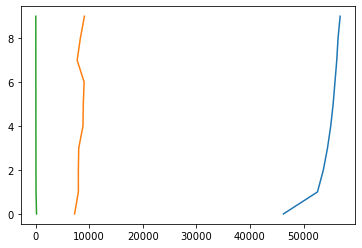

Wall time: 15min 38s


In [13]:
%%time
train_net(net, train_iter, test_iter, n_epochs=10)